In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from dataset_loading import CocoLoader
import torch
import numpy as np
from matplotlib import colormaps
import torchvision

import os

from sam_utils import *

In [3]:

#CUDA tests
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #might not be viable, check again!

print("CUDA available:" + str(torch.cuda.is_available()))
from torch.utils.cpp_extension import CUDA_HOME
print("CUDA_HOME:" + str(CUDA_HOME))
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#wont work for some reason
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(available_gpus)
print(torch.cuda.device_count())

#this will work, stays in the jupyter memory unless removed
test_tensor = torch.tensor(np.ones(100000000)).cuda()
del(test_tensor)
torch.cuda.empty_cache()

CUDA available:True
CUDA_HOME:/home.stud/svobo114/.conda/envs/detect_env_clone
1


In [4]:
coco=CocoLoader() #TODO: can add config here?
transforms = None
data_train, api = coco.load_train(transformations=transforms)
#data_val, api = coco.load_val(transformations=transforms) 



loading annotations into memory...
Done (t=13.44s)
creating index...
index created!
loading annotations into memory...
Done (t=8.66s)
creating index...
index created!


23933803
9524577


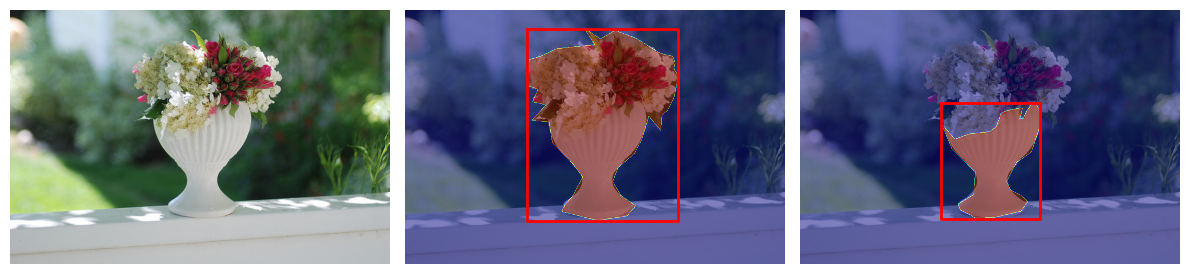

37360806


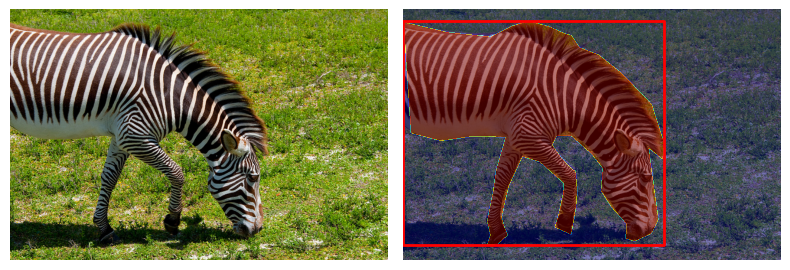

In [10]:
images_to_show =2
offset=2
scale=4

for i in range(images_to_show):
    item = data_train[offset+i]
    img = item[0]
    metadata = item[1]

    num_imgs = len(metadata)+1
    fig, axes = plt.subplots(1, num_imgs, figsize=(num_imgs * scale,  scale))
    axes=axes.flatten()

    for i,ax in enumerate(axes):
        if i==0: #straight up image
            ax.imshow(img)
            ax.axis('off')

        else: #+ masks
            rle = metadata[i-1]
            mask = api.annToMask(rle)
            ax.axis('off')
            ax.imshow(img)
            ax.imshow(mask, cmap='jet', alpha=0.5)
            print(np.sum(np.where(mask!=0)))

            box = rle['bbox']
            ax.plot([box[0], box[0] + box[2], box[0] + box[2], box[0], box[0]],
                    [box[1], box[1], box[1] + box[3], box[1] + box[3], box[1]],
                    color='red', linewidth=2)
    plt.tight_layout()
    plt.show()



[162.57, 226.56, 130.41, 184.43]
[81.7, 244.94, 83.71, 158.2]
[203.39, 260.43, 65.69, 73.04]
[118.43, 261.32, 56.91, 62.93]
[119.34, 334.21, 11.94, 33.57]
[201.77, 426.19, 70.84, 47.23]
[284.34, 333.4, 10.88, 27.43]
[191.0, 334.37, 7.16, 23.41]
[346.76, 333.4, 14.8, 9.22]


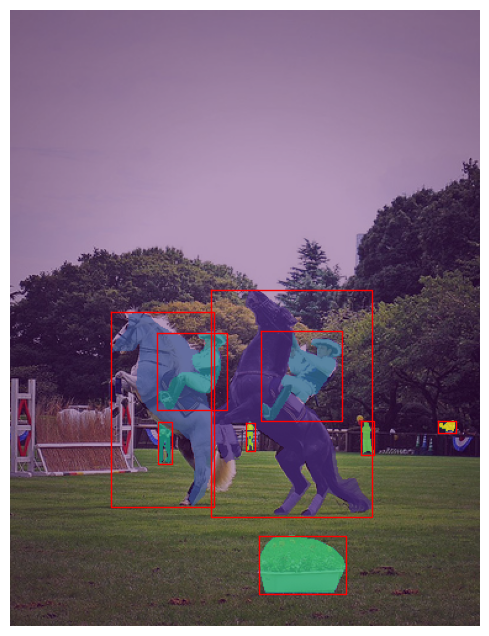

[261.2, 205.92, 48.08, 57.24]
[393.39, 210.34, 32.53, 39.74]
[370.11, 248.9, 83.09, 47.64]
[223.25, 250.1, 141.92, 77.71]
[261.54, 196.57, 34.21, 54.18]


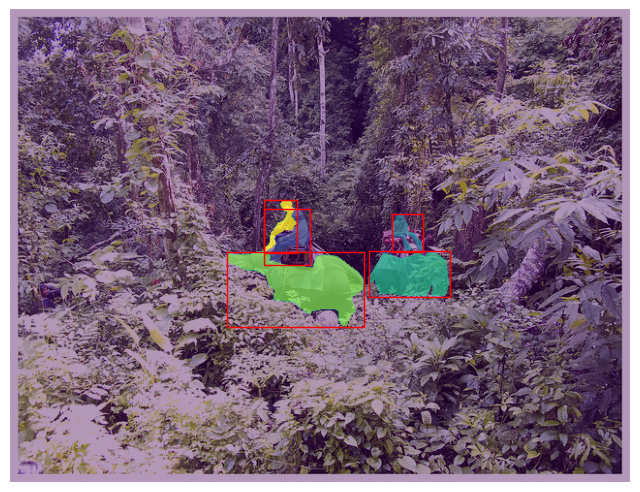

In [8]:
images_to_show =2
offset=6
scale=8
opacity=0.8
BG_MASK=True
#TODO: move to utils

for i in range(images_to_show):
    item = data_train[offset+i]
    img = item[0]
    metadata = item[1]

    plt.figure(figsize=(scale, scale))
    plt.imshow(img) #first image
    plt.axis('off')

    cmap =colormaps['autumn']
    num_images = len(metadata)
    alpha = np.ones_like(img)[:,:,0]*opacity

    mask_sum = np.zeros_like(img)[:,:,0]
    for i,rle in enumerate(metadata):
        mask = api.annToMask(rle)
        mask_sum = np.maximum(mask_sum,mask*(i+1))
    if not BG_MASK: alpha[np.where(mask_sum==0)] = 0
    else: alpha[np.where(mask_sum==0)] = opacity/2
    plt.imshow(mask_sum, cmap='viridis', alpha=alpha) #TODO:  show just the masked part with color and not the rest?

    for i,rle in enumerate(metadata): #all masks
        box = rle['bbox']
        print(box)
        plt.plot([box[0], box[0] + box[2], box[0] + box[2], box[0], box[0]],
                [box[1], box[1], box[1] + box[3], box[1] + box[3], box[1]],
                #color=cmap(i/num_images), linewidth=1)
                color='red', linewidth=1)

    plt.show()


In [10]:
from segment_anything import SamPredictor, sam_model_registry

sam_checkpoint = "/datagrid/personal/janoukl1/out/ImDec/ckpts/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
#loads sam predictor model

/home.stud/svobo114/.conda/envs/detect_env_clone/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t

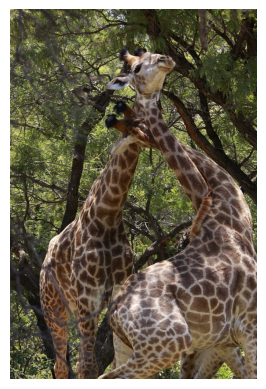

In [13]:
pos = 10
test_image = data_train[pos][0] #take po-th image, and leave the metadata

plt.axis('off')
plt.imshow(test_image)

test_image=np.asarray(test_image)
predictor.set_image(test_image)

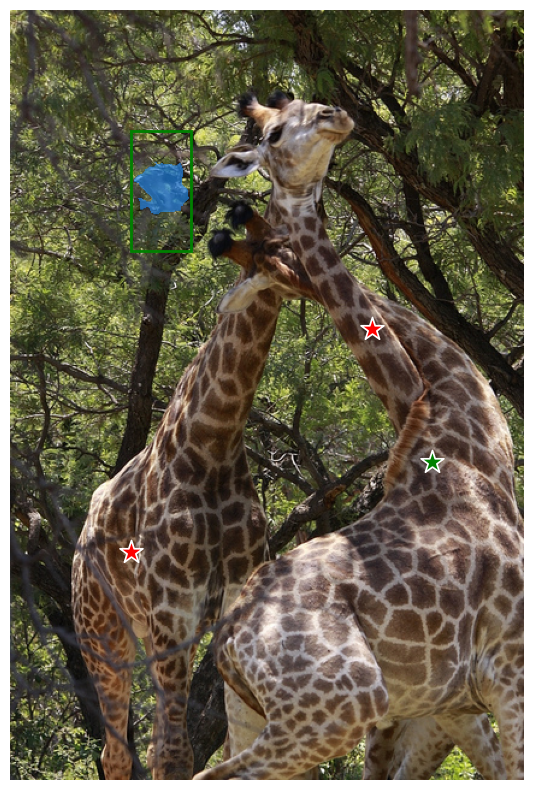

In [18]:
#prompt by box (can be with box & points, or just box)
input_box = np.array([100, 100, 150, 200])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=False,
)
plt.figure(figsize=(10, 10))
plt.imshow(test_image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

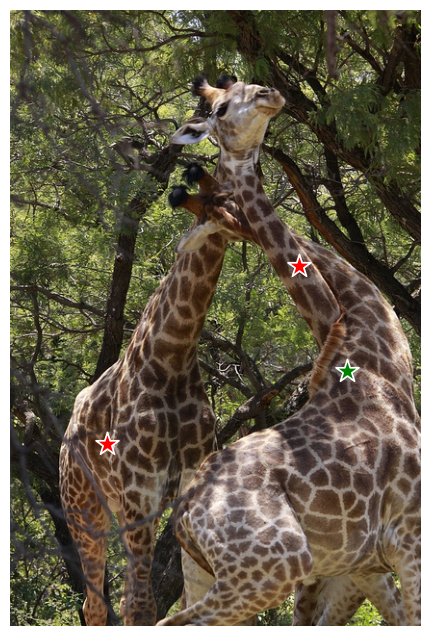

In [50]:
#prompt by point
scale=8
input_point = np.array([[350, 375],[300,265],[100,450]])
input_label = np.array([1,0,0]) #pos, neg, neg

plt.figure(figsize=(scale,scale))
plt.imshow(test_image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

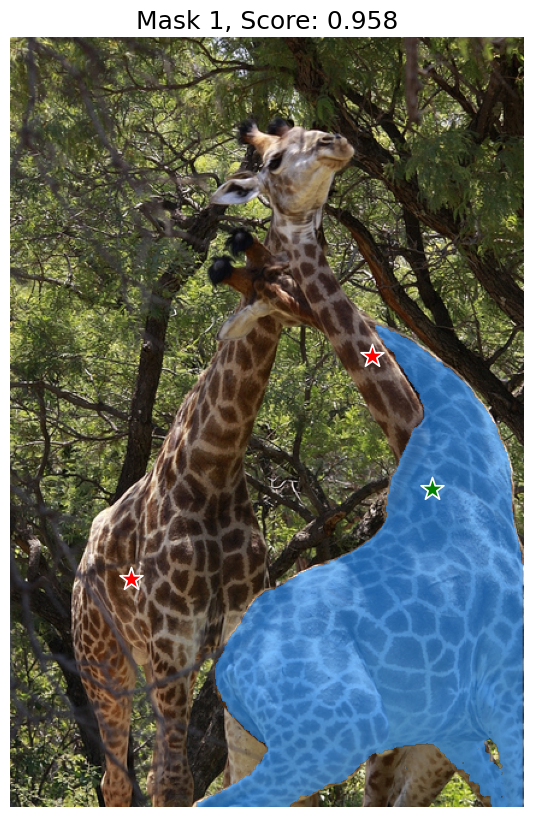

In [52]:

def print_masks(masks, scores):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(test_image)
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show() 


masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)
print_masks(masks, scores)

In [ ]:
def segment_for_box(bbox, predictor, test_image):
    x,y,w,h = bbox
    #"cut out" the box
    #load to sam
    #predict by bbox! modes: points,bbox +mask?
    #return masks, scores

    predictor.set_image(test_image)
    masks, scores, logits = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        multimask_output=True,
    )
    return masks, scores

#the choose a mask?

In [ ]:
images_to_show =3
offset=6
scale=8
opacity=0.8
BG_MASK=True

for i in range(images_to_show):
    item = data_train[offset+i]
    img = item[0]
    metadata = item[1]

    plt.figure(figsize=(scale, scale))
    plt.imshow(img) #first image
    plt.axis('off')

    cmap =colormaps['autumn']
    num_images = len(metadata)
    alpha = np.ones_like(img)[:,:,0]*opacity

    mask_sum = np.zeros_like(img)[:,:,0]
    for i,rle in enumerate(metadata):
        mask = api.annToMask(rle)
        mask_sum = np.maximum(mask_sum,mask*(i+1))
    if not BG_MASK: alpha[np.where(mask_sum==0)] = 0
    else: alpha[np.where(mask_sum==0)] = opacity/2
    plt.imshow(mask_sum, cmap='viridis', alpha=alpha) #TODO:  show just the masked part with color and not the rest?

    for i,rle in enumerate(metadata): #all masks
        box = rle['bbox']
        
        plt.plot([box[0], box[0] + box[2], box[0] + box[2], box[0], box[0]],
                [box[1], box[1], box[1] + box[3], box[1] + box[3], box[1]],
                #color=cmap(i/num_images), linewidth=1)
                color='red', linewidth=1)

    plt.show()

In [ ]:
#same logic as in detection_pipeline.py (eventually)
GTboxes=[]
for item in data_train: 
    img = item[0]
    metadata = item[1]
    bboxes_per_img = [] #unknown number of objects
    for mask in metadata:
        box = mask['bbox']
        bboxes_per_img.append(box)
        # TODO: additional logic for masks later 
    GTboxes.append(bboxes_per_img)
        
    #use model to predict BBox
    #compare with GT in GTBBox (torchmetrics!)
    #   iou defined in pycocotools too

    break


In [3]:
from mvits_for_class_agnostic_od.inference.main import main
#trying to load mvit model

ModuleNotFoundError: No module named 'models'